In [1]:
!pip install yfinance

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from scipy.optimize import minimize
from scipy.stats import linregress
import matplotlib.pyplot as plt


In [3]:
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [4]:
end_date = datetime.today()

In [5]:
start_date = end_date - timedelta(days = 5*365)
print(start_date)

2021-01-31 23:11:21.837123


In [6]:
adj_close_df = pd.DataFrame()

In [7]:
for ticker in tickers:
    data = yf.download(ticker, start = start_date,end = end_date)
    adj_close_df[ticker] = data['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
print(adj_close_df)

                   SPY        BND         GLD         QQQ         VTI
Date                                                                 
2021-02-01  351.201874  75.103195  174.229996  312.885437  183.868881
2021-02-02  356.167908  75.008644  172.110001  317.989838  186.506256
2021-02-03  356.447906  74.879593  171.850006  316.728302  186.785828
2021-02-04  360.499207  74.896782  168.149994  320.474182  189.152939
2021-02-05  361.918152  74.793564  169.809998  321.561066  190.215286
...                ...        ...         ...         ...         ...
2026-01-26  692.729980  74.339996  464.700012  625.460022  342.029999
2026-01-27  695.489990  74.279999  476.100006  631.130005  343.269989
2026-01-28  695.419983  74.250000  494.559998  633.219971  343.079987
2026-01-29  694.039978  74.260002  495.899994  629.429993  342.290009
2026-01-30  690.109985  74.235001  449.649994  623.209900  339.809998

[1256 rows x 5 columns]


In [9]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [10]:
log_returns = log_returns.dropna()

In [11]:
cov_matrix = log_returns.cov() * 252  # Annualized covariance matrix  
print(cov_matrix)

          SPY       BND       GLD       QQQ       VTI
SPY  0.028910  0.001957  0.003307  0.036255  0.029441
BND  0.001957  0.003605  0.003065  0.002619  0.002060
GLD  0.003307  0.003065  0.027020  0.003992  0.003521
QQQ  0.036255  0.002619  0.003992  0.050704  0.036986
VTI  0.029441  0.002060  0.003521  0.036986  0.030281


In [12]:
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)


In [13]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252  # Annualized expected return

In [14]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [15]:
def portfolio_beta(weights, log_returns, market_col='SPY'):
    market_returns = log_returns[market_col]
    
    betas = []
    for col in log_returns.columns:
        cov = np.cov(log_returns[col], market_returns)[0][1]
        var = np.var(market_returns)
        betas.append(cov / var)
    
    betas = np.array(betas)
    return np.dot(weights, betas)


In [16]:
def treynor_ratio(weights, log_returns, risk_free_rate, market_col='SPY'):
    beta_p = portfolio_beta(weights, log_returns, market_col)
    return (expected_return(weights, log_returns) - risk_free_rate) / beta_p


In [17]:
def market_return(log_returns, market_col='SPY'):
    return log_returns[market_col].mean() * 252


In [18]:
def jensens_alpha(weights, log_returns, risk_free_rate, market_col='SPY'):
    Rp = expected_return(weights, log_returns)
    Rm = market_return(log_returns, market_col)
    beta_p = portfolio_beta(weights, log_returns, market_col)
    
    return Rp - (risk_free_rate + beta_p * (Rm - risk_free_rate))


In [19]:
risk_free_rate = 0.06  # 6% annual risk-free rate

In [20]:
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [21]:
def portfolio_beta(weights, log_returns, market_col='SPY'):
    market_returns = log_returns[market_col]
    
    betas = np.array([
        np.cov(log_returns[col], market_returns)[0][1] / np.var(market_returns)
        for col in log_returns.columns
    ])
    
    return np.dot(weights, betas)


In [22]:
def treynor_ratio(weights, log_returns, risk_free_rate, market_col='SPY'):
    return (
        expected_return(weights, log_returns) - risk_free_rate
    ) / portfolio_beta(weights, log_returns, market_col)


In [23]:
def neg_treynor_ratio(weights, log_returns, risk_free_rate):
    return -treynor_ratio(weights, log_returns, risk_free_rate)



In [24]:
def jensens_alpha(weights, log_returns, risk_free_rate, market_col='SPY'):
    Rp = expected_return(weights, log_returns)
    Rm = log_returns[market_col].mean() * 252
    beta_p = portfolio_beta(weights, log_returns, market_col)
    
    return Rp - (risk_free_rate + beta_p * (Rm - risk_free_rate))


In [25]:
def neg_jensens_alpha(weights, log_returns, risk_free_rate):
    return -jensens_alpha(weights, log_returns, risk_free_rate)



In [26]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

In [27]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [28]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_treynor = minimize(
    neg_treynor_ratio,
    initial_weights,
    args=(log_returns, risk_free_rate),
    method='SLSQP',
    constraints=constraints,
    bounds=bounds
)

optimized_alpha = minimize(
    neg_jensens_alpha,
    initial_weights,
    args=(log_returns, risk_free_rate),
    method='SLSQP',
    constraints=constraints,
    bounds=bounds
)

In [29]:
optimal_weights = optimized_results.x
optimal_weights_treynor = optimized_treynor.x
optimal_weights_jensen = optimized_alpha.x


In [30]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")

    print()

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)
optimal_treynor_ratio = treynor_ratio(optimal_weights, log_returns, risk_free_rate)
optimal_jensens_alpha = jensens_alpha(optimal_weights, log_returns, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")
print(f"Treynor Ratio: {optimal_treynor_ratio:.4f}")
print(f"Jensen's Alpha: {optimal_jensens_alpha:.4f}")

Optimal Weights:
SPY: 0.5000

BND: 0.0000

GLD: 0.5000

QQQ: 0.0000

VTI: 0.0000

Expected Annual Return: 0.1630
Expected Volatility: 0.1250
Sharpe Ratio: 0.8237
Treynor Ratio: 0.1847
Jensen's Alpha: 0.0608


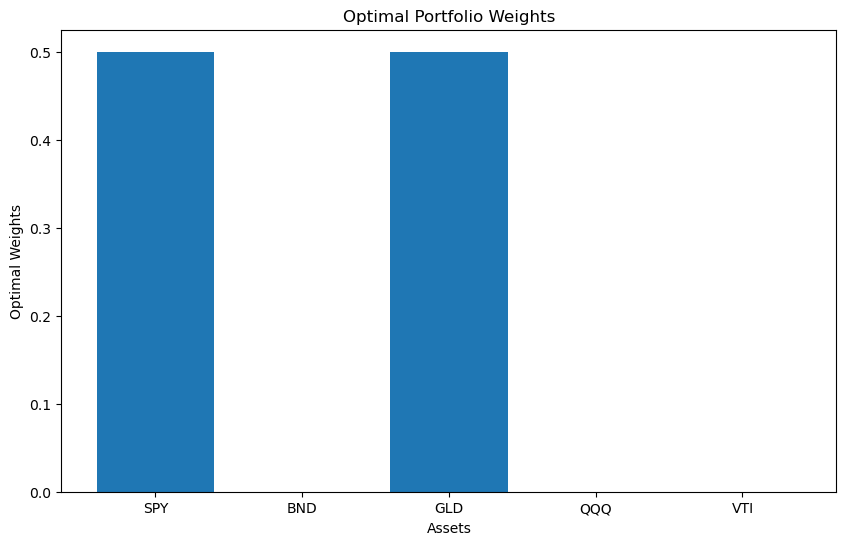

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()

In [32]:
portfolio_returns = log_returns @ optimal_weights


In [33]:
actual_direction = np.sign(portfolio_returns.shift(-1))              # Directional Accuracy %
predicted_direction = np.sign(portfolio_returns)

accuracy = (actual_direction == predicted_direction).mean() * 100
print(f"Directional Accuracy (%): {accuracy:.2f}")


Directional Accuracy (%): 52.51


In [34]:
from sklearn.model_selection import TimeSeriesSplit


In [35]:
tscv = TimeSeriesSplit(n_splits=5)                                  # Cross-Validation Score (Time-Series CV)
cv_sharpe_scores = []

for train_idx, test_idx in tscv.split(log_returns):
    train_returns = log_returns.iloc[train_idx]
    test_returns = log_returns.iloc[test_idx]
    
    cov_train = train_returns.cov() * 252
    
    sharpe = sharpe_ratio(
        optimal_weights,
        test_returns,
        cov_train,
        risk_free_rate
    )
    
    cv_sharpe_scores.append(sharpe)


In [36]:
print("Cross-Validation Sharpe Scores:", cv_sharpe_scores)
print("Mean CV Sharpe Score:", np.mean(cv_sharpe_scores))


Cross-Validation Sharpe Scores: [-2.2968374774172253, 1.4747004785415458, 1.1113985024374422, 1.3706252079051628, 2.9038062599264154]
Mean CV Sharpe Score: 0.9127385942786681


In [37]:
split = int(0.7 * len(log_returns))      # Out-of-Sample Validation
train = log_returns.iloc[:split]
test = log_returns.iloc[split:]

cov_train = train.cov() * 252

test_sharpe = sharpe_ratio(
    optimal_weights,
    test,
    cov_train,
    risk_free_rate
)

print("Out-of-Sample Sharpe Ratio:", test_sharpe)


Out-of-Sample Sharpe Ratio: 2.23157621009721
